# Exploring and cleaning the tweet data

### Imports

In [48]:
#imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import regex
import emoji
import pickle

### Reading in Data

In [2]:
data = pd.read_csv('../Protected/Data/corpus_with_text.csv')

In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8380 entries, 0 to 8379
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   8380 non-null   int64 
 1   text    8380 non-null   object
dtypes: int64(1), object(1)
memory usage: 131.1+ KB


### Tokenizing and Lemmatizing

In [4]:
def tok_and_lem(dataframe, new_column, input_column,handles = True, tok = True, lem = True):
    tokenizer = TweetTokenizer(strip_handles = handles)
    lemmatizer = WordNetLemmatizer()
    #tokenizing
    dataframe[new_column] = [tokenizer.tokenize(row) for row in dataframe[input_column]]
    #lemmatizing and joining the text back together 
    for row in dataframe.index:
        dataframe[new_column].iloc[row] = ' '.join([lemmatizer.lemmatize(word) for word in dataframe[new_column][row]])
    #example of what the data looks like
    return dataframe[new_column]

In [5]:
tok_and_lem(data,'text_processed','text')

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0       plz excuse me while I cry . I DONT even know w...
1       you had me til the goat cheese ... What's next...
2       Either way , I should go get a flu shot . And ...
3       and form them into something we like yep make ...
4                                         thanks mate ...
                              ...                        
8375    You don't . I have purchased a lot on Amazon (...
8376    #Emotions you say 🤔 never knew that I think I ...
8377    You are so right ... " Yes ! #Silence is not #...
8378    Another lazy delusional voter who take the wor...
8379    I hope you know no news outlet from Nigeria ha...
Name: text_processed, Length: 8380, dtype: object

## Exploring Emoji use

In [6]:
#First, using the emoji library I'll collect a list of all unique emojis in the corpus
emoji_list=[]
for row in data['text']:
    for c in row:
        if c in emoji.UNICODE_EMOJI:
            emoji_list.append(c)
emoji_list =  list(set(emoji_list))
print(len(emoji_list))
print(emoji_list[0:10])

336
['🤪', '💞', '🍽', '🇿', '📺', '🤦', '🍫', '😉', '😳', '✊']


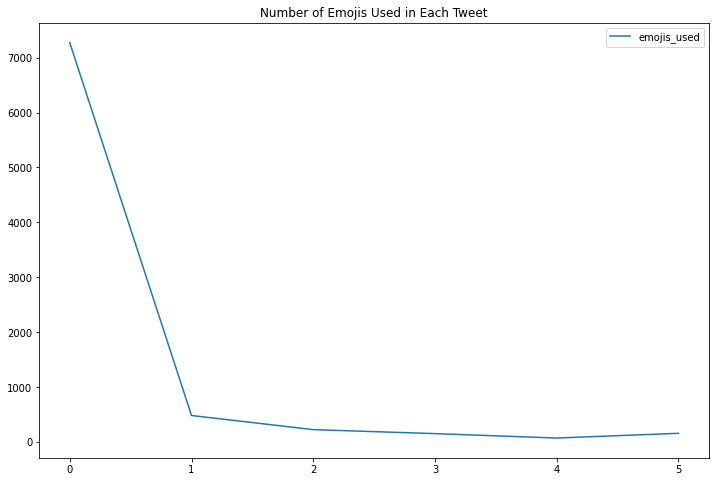

In [7]:
#using the emoji_list to identify and count the emojis in each tweet
def is_emoji(s):
    emojis = emoji_list # add more emojis here
    count = 0
    for emoji in emojis:
        count += s.count(emoji)
    return count

data['emojis_used'] = data['text_processed'].apply(is_emoji)

(pd.DataFrame(data['emojis_used'].value_counts()).sort_index()).plot(figsize = (12,8))
plt.title("Number of Emojis Used in Each Tweet");

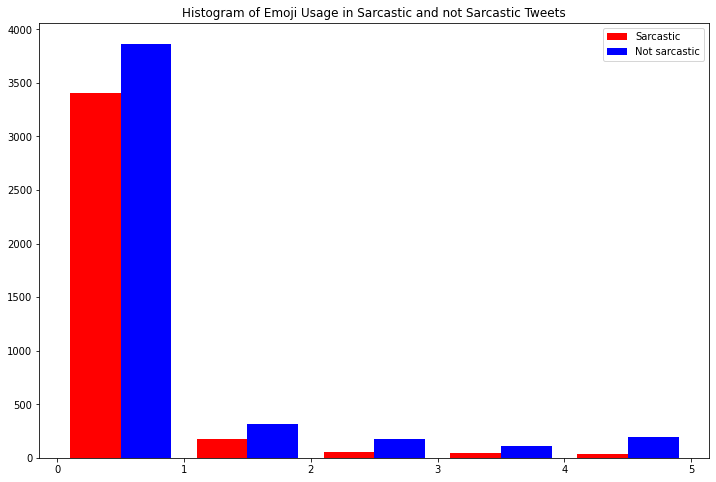

In [8]:
# Let's see how emoji usage relates to the labeling of sarcastic or not
plt.figure(figsize = (12,8))
plt.hist([data.loc[data['label']==1]['emojis_used'], data.loc[data['label']==0]['emojis_used']], bins = [0,1,2,3,4,5], color = ['Red','Blue'])
plt.legend(labels = ['Sarcastic','Not sarcastic'])
plt.title('Histogram of Emoji Usage in Sarcastic and not Sarcastic Tweets');

In [9]:
#It doesn't look like there is much of a relationship between number of emojis and the positive class
data[['label','emojis_used']].corr()

,label,emojis_used
label,1.000000,-0.135048
emojis_used,-0.135048,1.000000


## Sentiment Analysis exploration

In [10]:
sentiment = SentimentIntensityAnalyzer()

data['neg_sentiment'] = [sentiment.polarity_scores(row)['neg'] for row in data['text']]
data['pos_sentiment'] = [sentiment.polarity_scores(row)['pos'] for row in data['text']]
data['neu_sentiment'] = [sentiment.polarity_scores(row)['neu'] for row in data['text']]
data['comp_sentiment'] = [sentiment.polarity_scores(row)['compound'] for row in data['text']]

<AxesSubplot:>

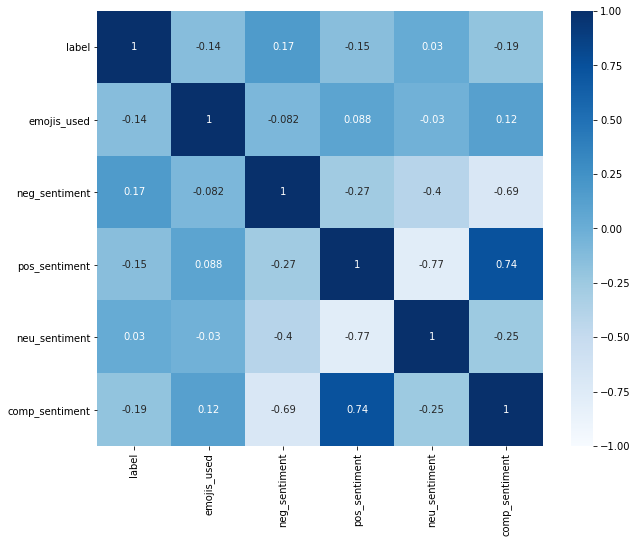

In [14]:
#heatmap of the correlation between features. 
plt.figure(figsize = (10,8))
sns.heatmap(data.corr(), vmin = -1, vmax = 1, annot = True, cmap = "Blues")

In [18]:
data.drop(columns = ['text']).head()

,label,text_processed,emojis_used,neg_sentiment,pos_sentiment,neu_sentiment,comp_sentiment
0,1,plz excuse me while I cry . I DONT even know w...,0,0.110,0.248,0.641,0.4336
1,1,you had me til the goat cheese ... What's next...,3,0.000,0.000,1.000,0.0000
2,1,"Either way , I should go get a flu shot . And ...",0,0.157,0.000,0.843,-0.3818
3,1,and form them into something we like yep make ...,0,0.135,0.276,0.588,0.3400
4,1,thanks mate ...,0,0.000,0.592,0.408,0.4404


In [19]:
#example text with emojis
data['text_processed'].iloc[1]

"you had me til the goat cheese ... What's next ? Yaks ' milk ? Lol 🐐 🐐 🐐"

In [20]:
data.to_csv('../Protected/Data/corpus_processed.csv', index = False)